<a href="https://colab.research.google.com/github/itberrios/CV_tracking/blob/main/setup_tutorials/tutorial_yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Yolo V5 Tutorial**

In this tutorial we will learn how to import and run the YOLO object detector with just a few lines of code. This will be a quick hands on tutorial, for more information about single shot detectors and YOLO please see this series of [blogposts](https://pyimagesearch.com/2022/04/04/introduction-to-the-yolo-family/). NOTE: If you are using Colab, be sure to select GPU as the hardware accelerator. Now let's get started!

<br>
TL-DR

If you just want to see how to use YOLOv5 on your own image/video here are the steps:

1. clone the yolov5 repository
2. install requirements
3. grab the model from torchhub

```
!git clone https://github.com/ultralytics/yolov5 # clone repository
!pip install -r yolov5/requirements.txt  #Install whatever is needed

# get the model
import torch
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

# run model on image
detections = model(image)

# display bounding boxes on image
detections.show()
```

<br>
<br>

First we will grab some data to run our object detector on. For this we will use pytube to obtain a YouTube video

In [1]:
!pip install pytube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 4.5 MB/s 


In [2]:
from pytube import YouTube

To download a YouTube video we can just pass the url to the YouTube class. We are using a string literal ('r') to avoid url errors. See the [pyTube documentation](https://pytube.io/en/latest/)

In [3]:
video_url = r'https://www.youtube.com/watch?v=G76ThtqLvWk'
yt = YouTube(video_url)
yt.title

"The Fate of the Furious (2017) - Harpooning Dom's Car Scene (6/10) | Movieclips"

In [4]:
yt.streams \
  .filter(progressive=True, file_extension='mp4') \
  .order_by('resolution') \
  .desc() \
  .first() \
  .download() 

'/content/The Fate of the Furious (2017) - Harpooning Doms Car Scene (610)  Movieclips.mp4'

In [5]:
!ls

 sample_data
'The Fate of the Furious (2017) - Harpooning Doms Car Scene (610)  Movieclips.mp4'


We will use moviepy to get the frame rate and handle audio, we will use opencv to open the video and obtain the video frames. We will only use the first 2000 frames to make things go faster and to make sure we don't run out of memory on Colab.

In [6]:
!pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.4 MB/s 


In [8]:
# bug fix for imageio-ffmpeg
!pip install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 28.5 MB/s 
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303885 sha256=94f76f2fae10e611a6919f6e0a7045fe90d6390b8ff68b19b6d0782dc14f0410
  Stored in directory: /root/.cache/pip/wheels/46/20/07/7bb9c8c44e6ec2efa60fd0e6280094f53f65f41767ef69a5ee
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0


In [90]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### Use moviepy to get the Frame Rate and add audio back to our detection video later.

In [91]:
from moviepy.editor import VideoFileClip

video_path = '/content/The Fate of the Furious (2017) - Harpooning Doms Car Scene (610)  Movieclips.mp4'
videoclip = VideoFileClip(video_path)
audioclip = videoclip.audio

In [92]:
video_fps = videoclip.fps
video_fps

23.976023976023978

In [93]:
audioclip.fps

44100

### Now let's get the video frames using opencv2

In [22]:
cap = cv2.VideoCapture(video_path)

if (cap.isOpened() == False):
    print("Error opening video file")

frames = []
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(image)

        if i == 2000:
            break
        else:
           i += 1

    # Break the loop
    else:
        break
 
# When everything done, release
# the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [94]:
print(f'Number of frames: {len(frames)}')

print(f'Shape of a frame: {frames[0].shape}')

video_length = len(frames)/video_fps
print(f'Length of video read by opencv: {video_length} seconds')

Number of frames: 2001
Shape of a frame: (720, 1280, 3)
Length of video read by opencv: 83.45837499999999 seconds


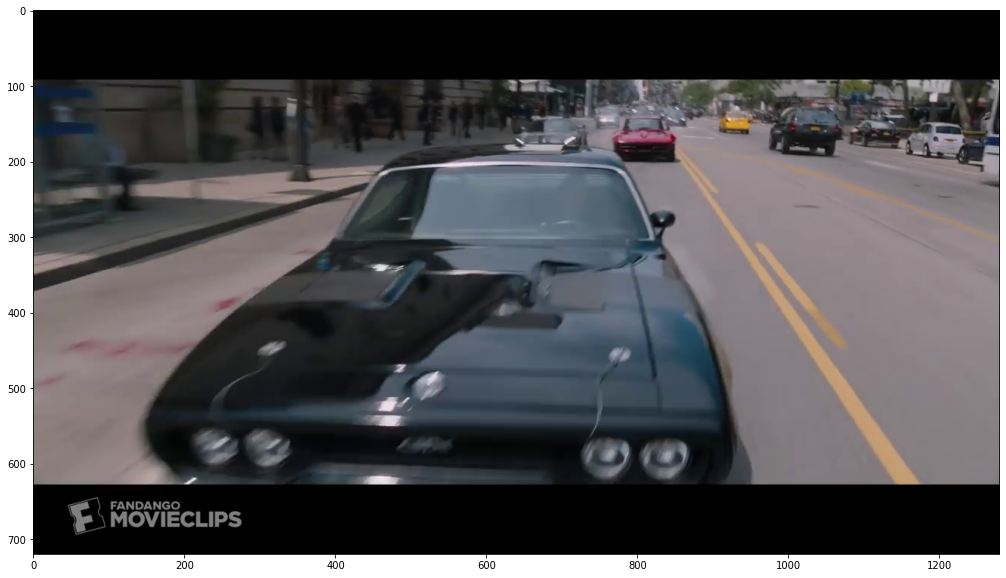

In [95]:
plt.imshow(frames[1000]);

## **Get YOLO**

Now we will obtain YOLOv5 and run it on the video. Once again we will do this in 3 steps:
1. clone the yolov5 repository
2. install requirements
3. grab the model from torchhub

In [11]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12266, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 12266 (delta 31), reused 38 (delta 19), pack-reused 12198
Receiving objects: 100% (12266/12266), 12.69 MiB | 6.01 MiB/s, done.
Resolving deltas: 100% (8436/8436), done.


In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [68]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-9-10 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [101]:
# set confidence and IOU thresholds
model.conf = 0.35  # confidence threshold (0-1), default: 0.25
model.iou = 0.35   # NMS IoU threshold (0-1), default: 0.45

### Now pass a test image through the model

As long as the image has a standard (or close to standard size and aspect ratio) There is no need to resize the image. YOLO was trained to handle different image sizes and apsects. Also we don't need to worry about adding a batch dimension or changing the type, we can just pass in numpy arrays.

In [102]:
test_image = frames[1000].copy()
detections = model(test_image)

Even without a GPU instance running obejct detection only takes a couple of seconds. If GPU is available the model will use it. Now we can draw the boxes with categories and confidence on our test image. NOTE: this method will overwrite the image that was input into yolo.

In [103]:
# draw boxes on input image
detections.show()

Get bounding box (xy, xy) locations, confidence, and [MSCOCO category](https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/)

In [104]:
# get bounding box (xy, xy) locations, confidence, and MSCOCO category
detections.xyxy

[tensor([[9.74245e+02, 1.25572e+02, 1.07043e+03, 1.92210e+02, 8.70171e-01, 2.00000e+00],
         [1.47306e+02, 1.83805e+02, 9.21420e+02, 6.15937e+02, 8.46164e-01, 2.00000e+00],
         [1.15394e+03, 1.49512e+02, 1.23284e+03, 1.96269e+02, 8.23088e-01, 2.00000e+00],
         [7.66115e+02, 1.37526e+02, 8.52857e+02, 2.02903e+02, 8.21501e-01, 2.00000e+00],
         [1.08730e+03, 1.40704e+02, 1.16132e+03, 1.82641e+02, 6.99227e-01, 2.00000e+00],
         [9.07273e+02, 1.30636e+02, 9.51775e+02, 1.64058e+02, 6.97379e-01, 2.00000e+00],
         [1.25501e+03, 1.62784e+02, 1.28000e+03, 2.25196e+02, 6.76609e-01, 2.00000e+00],
         [6.35608e+02, 1.41305e+02, 7.39307e+02, 1.87516e+02, 6.67408e-01, 2.00000e+00],
         [5.10381e+02, 1.19887e+02, 5.32710e+02, 1.79790e+02, 5.50720e-01, 0.00000e+00],
         [4.11062e+02, 1.16273e+02, 4.45723e+02, 1.87922e+02, 5.05681e-01, 0.00000e+00],
         [1.22196e+03, 1.54502e+02, 1.26568e+03, 2.07266e+02, 4.79327e-01, 2.00000e+00]], device='cuda:0')]

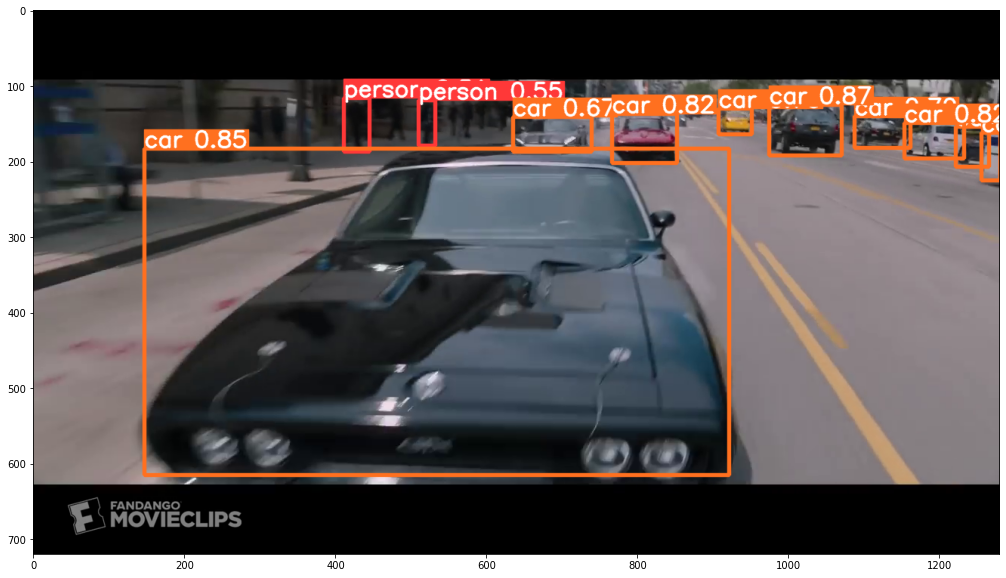

In [105]:
plt.imshow(test_image);

#### Now run yolo on all the frames and make a video!

In [106]:
from tqdm import tqdm

In [107]:
result_video = []

for frame in tqdm(frames):
    
    # run object detection on current frame
    detections = model(frame)

    # draw boxes on the image
    detections.show()

    result_video.append(frame)

# get width and height for video frames
h, w, _ = frame.shape

# save to mp4
out = cv2.VideoWriter('fast_and_furous_detections.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'), 
                      video_fps,
                      (w, h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_RGB2BGR))
out.release()

100%|██████████| 2001/2001 [00:36<00:00, 54.75it/s]


You can see that Yolo performs at roughly 60 frames per second on a GPU, which pretty good.

## Now we will add audio back to our video

In [108]:
# trim audio file to length of video
audioclip_trimmed = audioclip.subclip(0, video_length)

In [109]:
from moviepy.editor import CompositeAudioClip
detection_video = VideoFileClip('fast_and_furous_detections.mp4')
# audioclip = AudioFileClip("audioname.mp3")

new_audioclip = CompositeAudioClip([audioclip_trimmed])
detection_video.audio = new_audioclip
detection_video.write_videofile('fast_and_furous_detections_with_audio.mp4')

[MoviePy] >>>> Building video fast_and_furous_detections_with_audio.mp4
[MoviePy] Writing audio in fast_and_furous_detections_with_audioTEMP_MPY_wvf_snd.mp3


100%|██████████| 1841/1841 [00:02<00:00, 652.58it/s]

[MoviePy] Done.


[MoviePy] Writing video fast_and_furous_detections_with_audio.mp4


100%|█████████▉| 2001/2002 [02:12<00:00, 17.25it/s]/usr/local/lib/python3.7/dist-packages/moviepy/video/io/ffmpeg_reader.py:130: UserWarning: Warning: in file fast_and_furous_detections.mp4, 2764800 bytes wanted but 0 bytes read,at frame 2001/2002, at time 83.46/83.46 sec. Using the last valid frame instead.
  UserWarning)

100%|██████████| 2002/2002 [02:12<00:00, 15.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: fast_and_furous_detections_with_audio.mp4 

